In [ ]:


import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'diabetic-retinopathy-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F4104%2F46661%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240727%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240727T161842Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D306ed16adaffc03156db3cdd3f1a192a9a4eb7a063e2b08668fc725777c0a37a328feb966b12d5144390ff2bb03af13cce8dc120b590b2f28de2b320e0820cee8d20b5e65445ca9fdddcf8c43efb41b143ebb67759eac5f7b43e6572c6007b08b4358bc885b0ecf4fa9f25ab5db1b25aad1d5fa5027c1795508cd2266ee1db4ae0579a04a07615ff68c5e7e8ef7e5ad30acb64dc060c4511e3d89d3c33d98343f15fc9561c868928ecf770d5582839e26b856279d97dd16589e35ba65765412f53cd118bba82d0a0d5c14d0ad03ec10549ae1260618d102fad840f0cc02f2a5a4e0f7350459aedb629b72f9ab98cde31cc73cebfae5dbb4ed146062f06a08096,prepossessed-arrays-of-binary-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F110097%2F265751%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240727%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240727T161843Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1b89a893764ba6e61f1e623d4b61f4ec1c11131a9a265d04b9c50d2e66afc5f974dc2d235f083223af101eea97f491a67b9a8070af2b6afa72d8d51bd5f773335498face79f8cce0a4cb21e341bee1a1c5331214edee52af903e0ea85c3d067aaaaea48f877205c4d8da85d794d5b88bad6e2a0c7d86d60190a257f3d1d7bcb47b34142d73abf01674978789de4bbb7a0304f8f345dea2f3fc6066090344fd8dc0189cc05eb8c1f7376e37f472d581356a4a6bcc68853ad7d1c335f1023bd09474e2c1ebd075938d83750fe9ef85ac874aa118eae208e3beb86fdb524a23792793df76d9318c9b19b3aa159ce3e6589cea7e7268bb9baf62c4b4f90bd0e7f70f,diabeticretinopathyddraptos2019messidorbalanced:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1366461%2F2269470%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240727%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240727T161843Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D49deeca62133dd9f05e4d2238564177dd3db87a7157f7ad9f04659d0ba1c64e9c0dfe96cb6e53d2d728ccff81db91b80e3931aaaeb9135e2a51e9961ec68661f5e776ea1f65d29b77a8cfee28221b142f2d844ba2c235a26076fcda89e1d52a5500656989659d8378b29bed5508dcb6bcf051f40d92ebd642cb34c2908e9dfbc63b870bdf77df0dafc5fe5c9999aa9c06447c3da605be908a9295bdbab235aeebe1369819f4286c0e0934da3ea25410acee1f2321196bb389241fcdb59ed900fc09ba690bfd0fb83e2b3b9a2fecf0db6998933c0df1451034a3a23f8243772eadb8b7627ae745fbf95ac9a8a6b2914a5644c345818a1c78046b7505e2d8f3d8b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# from keras.preprocessing.image import img_to_array
# from keras.preprocessing.image import array_to_img
# from sklearn.model_selection import train_test_split
# from PIL import Image
# import scipy

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
# import pydot
from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

# from tqdm import tqdm, tqdm_notebook
# from colorama import Fore
# import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
# import time
# from sklearn.decomposition import PCA
# from sklearn.svm import LinearSVC
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score
# import lightgbm as lgb
# import xgboost as xgb
# !pip install livelossplot
# import livelossplot
# from livelossplot import PlotLossesKeras
import warnings
warnings.filterwarnings('ignore')
print("All modules have been imported")

All modules have been imported


In [ ]:
!unzip ../input/diabetic-retinopathy-detection/trainLabels.csv.zip

Archive:  ../input/diabetic-retinopathy-detection/trainLabels.csv.zip
  inflating: trainLabels.csv         


## Importing labels

In [ ]:
import pandas as pd

trainLabels = pd.read_csv("./trainLabels.csv")

In [ ]:
!apt install p7zip-full -y
!7z x ../input/diabetic-retinopathy-detection/train.zip.001 "-i!train/11*.jpeg" -y # restrict extracted file to about 100 for the disk restriction
!mkdir data
!mv train data/train_11


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  p7zip
Suggested packages:
  p7zip-rar
The following NEW packages will be installed:
  p7zip p7zip-full
0 upgraded, 2 newly installed, 0 to remove and 42 not upgraded.
Need to get 1545 kB of archives.
After this operation, 5896 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 p7zip amd64 16.02+dfsg-7build1 [358 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 p7zip-full amd64 16.02+dfsg-7build1 [1187 kB]
Fetched 1545 kB in 2s (719 kB/s)    

78Selecting previously unselected package p7zip.
(Reading database ... 103272 files and directories currently installed.)
Preparing to unpack .../p7zip_16.02+dfsg-7build1_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [ 11%] [######.........................................

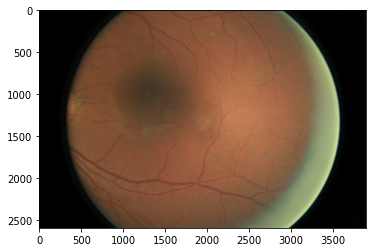

In [ ]:
from PIL import Image

img = Image.open("./data/train_11/1116_right.jpeg")

import matplotlib.pyplot as plt

plt.imshow(img)

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Filtering csv file

In [ ]:
import os
base_image_dir = os.path.join('.', 'data/train_11')
df = pd.read_csv(os.path.join('./trainLabels.csv'))
df['path'] = df['image'].map(lambda x: os.path.join(base_image_dir,'{}.jpeg'.format(x)))
df['exists'] = df['path'].map(os.path.exists) #Most of the files do not exist because this is a sample of the original dataset
df = df[df['exists']]
df = df.drop(columns=['image','exists'])
df = df.sample(frac=1).reset_index(drop=True)#shuffle dataframe
df['level'] = df['level'].astype(str)
df.head(10)

,level,path
0,0,./data/train_11/11370_right.jpeg
1,0,./data/train_11/11744_right.jpeg
2,0,./data/train_11/11665_right.jpeg
3,0,./data/train_11/11828_left.jpeg
4,2,./data/train_11/11647_left.jpeg
5,0,./data/train_11/11780_right.jpeg
6,0,./data/train_11/1197_right.jpeg
7,0,./data/train_11/11008_right.jpeg
8,0,./data/train_11/11091_left.jpeg
9,0,./data/train_11/11203_right.jpeg


### The dataset is highly imbalanced, with many samples for level 0, and very little for the rest of the levels.


<AxesSubplot:>

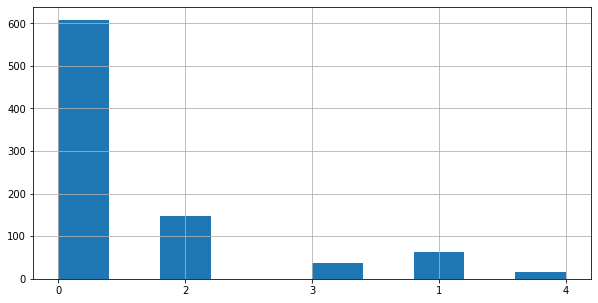

In [ ]:
df['level'].hist(figsize = (10, 5))

In [ ]:
def balance_data(class_size,df):
    train_df = df.groupby(['level']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['level'].hist(figsize = (10, 5))
    return train_df


175

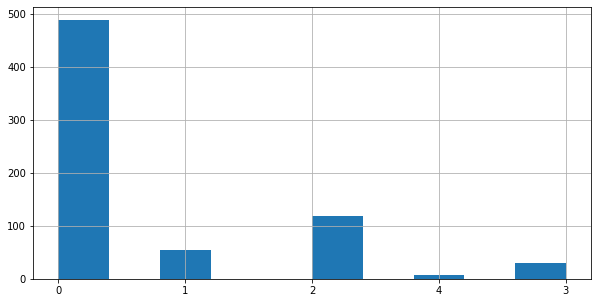

In [ ]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df,test_size=0.2) # Here we will perform an 80%/20% split of the dataset, with stratification to keep similar distribution in validation set
train_df['level'].hist(figsize = (10, 5))
len(val_df)

New Data Size: 2440 Old Size: 697


<AxesSubplot:>

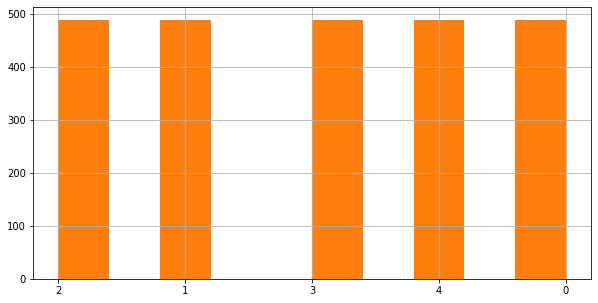

In [ ]:
train_df = balance_data(train_df.pivot_table(index='level', aggfunc=len).max().max(),train_df) # I will oversample such that all classes have the same number of images as the maximum
train_df['level'].hist(figsize = (10, 5))

In [ ]:
df = pd.concat([train_df,val_df]) #beginning of this dataframe is the oversampled training set, end is the validation set
len(df)

2615

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    horizontal_flip = True,
    zoom_range=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split = 0.2
)

In [ ]:
x_train = train_datagen.flow_from_dataframe(
        train_df,
        directory=".",
        x_col="path",
        y_col="level",
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')
x_test = test_datagen.flow_from_dataframe(
        val_df,
        x_col="path",
        y_col="level",
        directory=".",
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')

Found 2440 validated image filenames belonging to 5 classes.
Found 175 validated image filenames belonging to 5 classes.


In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## Image Data Generator

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
t_x, t_y = next(x_train)


## Showing some pics

In [ ]:
# plt.figure(figsize=(10, 10))
# for images, labels in x_train.take(1):
#   for i in range(6):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(classnames[labels[i]])
#     plt.axis("off")

## CNN Models

In [ ]:
def create_CNN_model(model):
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(264,264,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

In [ ]:
# def create_models(model_type):
#     model = Sequential()
#     if (model_type=="cnn"):
#         create_CNN_model(model)
#     elif(model_type == "resnet"):
#         pretrained_model= tf.keras.applications.ResNet50(include_top=False,
#                    input_shape=(256,256,3),
#                    pooling='avg',classes=5,
#                    weights='imagenet')
#         for layer in pretrained_model.layers:
#                 layer.trainable=False

#         model.add(pretrained_model)
#     elif(model_type == "googlenet"):
#         pretrained_model = tf.keras.applications.InceptionV3(
#                     include_top=True,
#                     weights="imagenet",
#                     input_shape=(299,299,3),
#                     pooling='avg',
#                     classes=1000)
#         for layer in pretrained_model.layers:
#                 layer.trainable=False
#         model.add(pretrained_model)

#     model.add(Flatten())
#     model.add(Dense(512, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(256, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(5, activation='softmax'))

#     model.compile(loss='categorical_crossentropy',
#                   optimizer=Adam(learning_rate=0.002),
#                   metrics=['accuracy',"AUC"])
#     return model;

from keras.applications.vgg16 import VGG16 as PTModel
from keras.applications.inception_resnet_v2 import InceptionResNetV2 as PTModel
from keras.applications.inception_v3 import InceptionV3 as PTModel
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
in_lay = Input(t_x.shape[1:])
base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
pt_depth = 2048
pt_features = base_pretrained_model(in_lay)
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)

# here we do an attention mechanism to turn pixels in the GAP on an off

attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(1,
                    kernel_size = (1,1),
                    padding = 'valid',
                    activation = 'sigmoid')(attn_layer)
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same',
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.25)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'relu')(gap_dr))
out_layer = Dense(t_y.shape[-1], activation = 'softmax')(dr_steps)
model = Model(inputs = [in_lay], outputs = [out_layer])
from keras.metrics import top_k_categorical_accuracy
def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy', top_2_accuracy])
model.summary()

87924736/87910968 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
inception_v3 (Functional)       (None, 6, 6, 2048)   21802784    input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 6, 6, 2048)   8192        inception_v3[0][0]               
__________________________________________________________________________________________________
dropout (Dropout)               (None, 6, 6, 2048)   0           batch_normalization_94[0][0]     
_____________________________

In [ ]:
# model = create_models("googlenet")

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
inception_v3 (Functional)       (None, 6, 6, 2048)   21802784    input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 6, 6, 2048)   8192        inception_v3[0][0]               
__________________________________________________________________________________________________
dropout (Dropout)               (None, 6, 6, 2048)   0           batch_normalization_94[0][0]     
______________________________________________________________________________________________

## Callbacks for Parameter Tuning

In [ ]:
filepath = "dr-detector.hdf5"
checkpoint = ModelCheckpoint(filepath,
                             monitor="val_top2_accuracy",
                             verbose=1,
                             save_best_only=True,
                             mode="max")

earlystop = EarlyStopping(monitor='val_categorical_accuracy',
                          verbose=1,
                          min_delta=0,
                          patience=15,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              verbose=1,
                              factor=0.2,
                              patience=6,
                              min_delta=0.0001,
                              cooldown=0,
                              min_lr=0.001)


callbacks = [checkpoint, earlystop, reduce_lr]

In [ ]:
history = model.fit(
        x_train,
        steps_per_epoch=x_train.samples // 64,
        epochs=50,
        validation_data=x_test,
        validation_steps=x_test.samples // 64,
        callbacks=callbacks)
model.save_weights("dr_messidor.h5")


Epoch 1/50
38/38 [==============================] - 171s 4s/step - loss: 1.1795 - categorical_accuracy: 0.5294 - top_2_accuracy: 0.7248 - val_loss: 1.9323 - val_categorical_accuracy: 0.1562 - val_top_2_accuracy: 0.4688
Epoch 2/50
38/38 [==============================] - 157s 4s/step - loss: 0.7270 - categorical_accuracy: 0.7237 - top_2_accuracy: 0.8849 - val_loss: 2.0743 - val_categorical_accuracy: 0.2656 - val_top_2_accuracy: 0.5781
Epoch 3/50
38/38 [==============================] - 162s 4s/step - loss: 0.5913 - categorical_accuracy: 0.7592 - top_2_accuracy: 0.9211 - val_loss: 1.3431 - val_categorical_accuracy: 0.3594 - val_top_2_accuracy: 0.7656
Epoch 4/50
38/38 [==============================] - 162s 4s/step - loss: 0.5566 - categorical_accuracy: 0.7796 - top_2_accuracy: 0.9359 - val_loss: 1.2189 - val_categorical_accuracy: 0.5156 - val_top_2_accuracy: 0.8125
Epoch 5/50
38/38 [==============================] - 157s 4s/step - loss: 0.4911 - categorical_accuracy: 0.8076 - top_2_accur

In [ ]:
# Evaluate on training and test data
train_results = model.evaluate(x_train, verbose=1)
test_results = model.evaluate(x_test, verbose=1)

# Extract the loss and accuracy values
train_loss = train_results[0]
train_accu = train_results[1]
test_loss = test_results[0]
test_accu = test_results[1]

# Print results
print("Final training accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))
print("Final training loss = {:.2f} , validation loss = {:.2f}".format(train_loss, test_loss))


6/6 [==============================] - 20s 3s/step - loss: 1.0854 - categorical_accuracy: 0.5886 - top_2_accuracy: 0.8743
Final training accuracy = 91.56 , validation accuracy = 58.86
Final training loss = 0.24 , validation loss = 1.09


In [ ]:
history.history
print(history.history.keys())


dict_keys(['loss', 'categorical_accuracy', 'top_2_accuracy', 'val_loss', 'val_categorical_accuracy', 'val_top_2_accuracy', 'lr'])


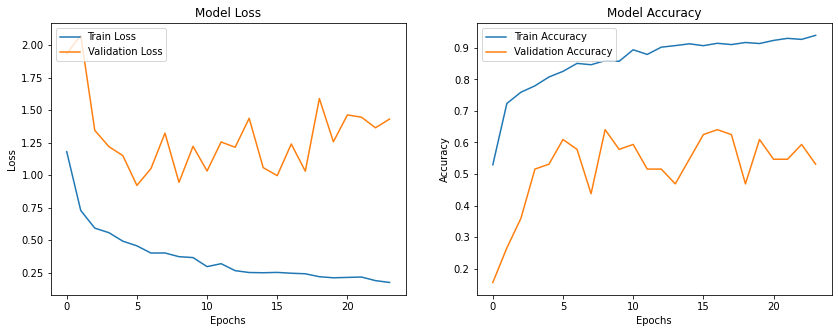

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))

# Plot accuracy
plt.subplot(1,2,2)
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()


Confusion Matrix
[[ 84 107  93 102 102]
 [100 109  88  99  92]
 [ 90  97  93 102 106]
 [ 91 108  98  93  98]
 [ 91 105  94 107  91]]
Classification Report
              precision    recall  f1-score   support

           0       0.18      0.17      0.18       488
           1       0.21      0.22      0.21       488
           2       0.20      0.19      0.19       488
           3       0.18      0.19      0.19       488
           4       0.19      0.19      0.19       488

    accuracy                           0.19      2440
   macro avg       0.19      0.19      0.19      2440
weighted avg       0.19      0.19      0.19      2440



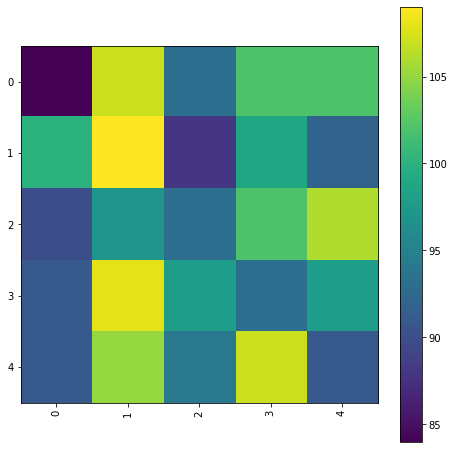

In [ ]:
y_pred = model.predict(x_train)
y_pred = np.argmax(y_pred, axis=1)
class_labels = x_test.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(x_train.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(x_train.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)